In [ ]:
!pip install numpy==1.24.4 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.3 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is 

In [ ]:
!pip install pycaret

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pycaret.regression import *
import xgboost as xg
import optuna


# Load Data

In [ ]:
train_df = pd.read_csv('training.csv', sep='\t', na_values='(null)')
val_df = pd.read_csv('validation.csv', sep='\t', na_values='(null)')

In [ ]:
train_df["DepartureDate"] = pd.to_datetime(train_df["DepartureDate"], dayfirst=True)
val_df["DepartureDate"] = pd.to_datetime(val_df["DepartureDate"],  dayfirst=True)


In [ ]:
print(val_df.shape)
val_df.head(2)

(1878, 13)


,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight
0,01/11/2016,2016,11,1,6003,MRS,BES,MRS-BES,84,3630,185.0,43.0,560.0
1,01/11/2016,2016,11,1,6004,BES,MRS,BES-MRS,86,3690,188.0,NaN,NaN


In [ ]:
print(train_df.shape)
train_df.head(2)

(29731, 14)


,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
0,01/10/2016,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,64016.0,175.0,61.0,440.0
1,01/10/2016,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,66138.0,182.0,27.0,350.0


# Data Analysis

In [ ]:
def plot_bars(df, title="", xlabel="", ylabel=""):
  plt.figure(figsize=(10, 6))
  df.plot(kind='bar')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()

def plot_line(df, title="", xlabel="", ylabel=""):
    plt.figure(figsize=(30, 6))
    df.plot(kind='line')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### Checking null values distibution

In [ ]:
count_colums_nulls = train_df.isnull().sum().reset_index()
count_colums_nulls.columns = ['column_name', 'null_count']
count_colums_nulls

,column_name,null_count
0,DepartureDate,0
1,DepartureYear,0
2,DepartureMonth,0
3,DepartureDay,0
4,FlightNumber,0
5,DepartureAirport,0
6,ArrivalAirport,0
7,Route,0
8,ActualFlightTime,0
9,ActualTotalFuel,0


,count
null_in_row,
0,26800
1,752
2,2034
3,110
4,35


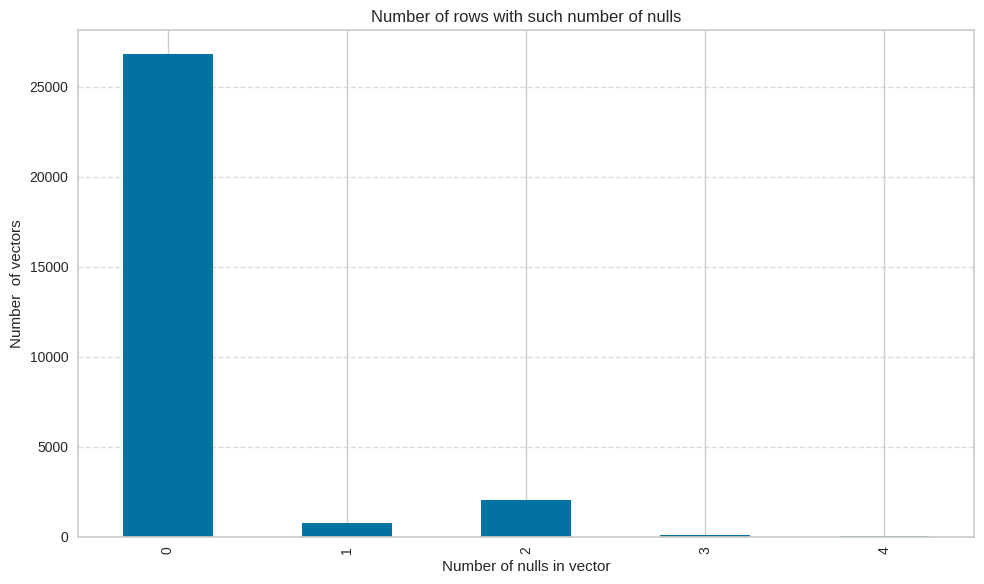

In [ ]:
count_rows_nulls = train_df.isnull().sum(axis=1).to_frame(name='null_in_row')
group_rows_nulls = count_rows_nulls['null_in_row'].value_counts().sort_index()
display(group_rows_nulls)
plot_bars(group_rows_nulls, title="Number of rows with such number of nulls", xlabel="Number of nulls in vector", ylabel="Number  of vectors")

### Unique values distribution

In [ ]:
train_nunique = train_df.nunique()
train_nunique

,0
DepartureDate,15
DepartureYear,1
DepartureMonth,1
DepartureDay,15
FlightNumber,3318
DepartureAirport,191
ArrivalAirport,190
Route,2667
ActualFlightTime,319
ActualTotalFuel,4402


### Date to ActualTOW dependence

<Figure size 3000x600 with 0 Axes>

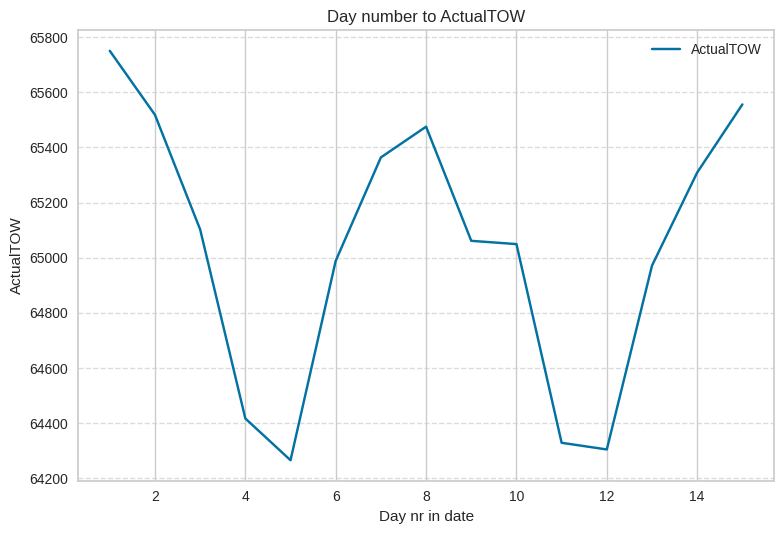

In [ ]:
date_tow = train_df[["DepartureDate", "ActualTOW"]]
date_tow["DepartureDay"] = date_tow["DepartureDate"].dt.day
date_tow = date_tow.groupby("DepartureDay").mean("ActualTOW")
plot_line(date_tow, title="Day number to ActualTOW", xlabel="Day nr in date", ylabel="ActualTOW")

As we can see there is weekly interval in analysed timeseries. That inspired me to represent date as week day (or 7d hot vector)

# Decisions after analysis:
- rows with null values in target will be removed
- representing days as day of week (0-6)
- year and month is constant so it will be ignored
- hypothesis — the 'route' column contains similar information as of 'DepartureAirport' and 'ArrivalAirport'. I think 2667 unique values may lead to training difficulties and could negatively affect model accuracy.
- 'FlightNumber' is just for identify flight. There is no information about generating (are these always increasing numbers?). I will replace it by other time related feature and check impact on RMSE.


# Feature selection

Removing columns 'DepartureDate', 'DepartureYear', 'DepartureMonth'

Adding 'DepartureWeekDay' with day as 0-6 number

Adding 'DepartureDayCounter' with nr of day from 2016-01-01 as an alternative to 'FlightNumber'

In [ ]:
train_processed_df = train_df
train_processed_df = train_processed_df.dropna(subset=['ActualTOW'])
train_processed_df["DepartureWeekDay"] = train_processed_df["DepartureDate"].dt.weekday
train_processed_df["DepartureDayCounter"] = (train_processed_df['DepartureDate'] - pd.to_datetime('2016-01-01')).dt.days

train_processed_df = train_processed_df.drop(['DepartureDate', 'DepartureDay', 'DepartureYear', 'DepartureMonth'], axis=1)
train_processed_df.head(2)

,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight,DepartureWeekDay,DepartureDayCounter
0,1145,MAN,SXF,MAN-SXF,91,3660,64016.0,175.0,61.0,440.0,5,274
1,1160,CTA,FCO,CTA-FCO,68,3280,66138.0,182.0,27.0,350.0,5,274


Checking hypothesis (point nr 4 from previous paragraph)

In [ ]:
include_Route = setup(
    data=train_processed_df,
    target='ActualTOW',
    session_id=42,
    normalize=True,
    categorical_features=['DepartureWeekDay', 'DepartureAirport', 'ArrivalAirport', 'Route'],
    ignore_features = ["DepartureDayCounter"]

)
include_Route = compare_models()
include_Route

,Description,Value
0,Session id,42
1,Target,ActualTOW
2,Target type,Regression
3,Original data shape,"(29298, 12)"
4,Transformed data shape,"(29298, 17)"
5,Transformed train set shape,"(20508, 17)"
6,Transformed test set shape,"(8790, 17)"
7,Ignore features,1
8,Numeric features,6
9,Categorical features,4


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,588.3161,821979.0625,904.4969,0.9267,0.0147,0.0092,0.5900
lightgbm,Light Gradient Boosting Machine,615.2801,887098.2670,939.7475,0.9208,0.0153,0.0096,3.3230
rf,Random Forest Regressor,647.3910,1003238.5640,999.8023,0.9105,0.0163,0.0101,18.2630
et,Extra Trees Regressor,654.3896,1007502.7958,1001.4398,0.9102,0.0163,0.0102,9.5680
gbr,Gradient Boosting Regressor,725.8707,1113812.8257,1054.4769,0.9005,0.0169,0.0113,4.0470
lasso,Lasso Regression,763.9001,1403233.4236,1181.2645,0.8748,0.0193,0.0119,0.2660
llar,Lasso Least Angle Regression,763.8940,1403249.7578,1181.2705,0.8748,0.0193,0.0119,0.2020
br,Bayesian Ridge,763.5944,1404041.3691,1181.5618,0.8747,0.0193,0.0119,0.3430
lar,Least Angle Regression,763.4990,1404135.5434,1181.5926,0.8747,0.0193,0.0119,0.2090
ridge,Ridge Regression,763.5314,1404091.6968,1181.5774,0.8747,0.0193,0.0119,0.3520


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
remove_Route = setup(
    data=train_processed_df,
    target='ActualTOW',
    session_id=42,
    normalize=True,
    categorical_features=['DepartureWeekDay', 'DepartureAirport', 'ArrivalAirport'],
    ignore_features = ['DepartureDayCounter', 'Route']

)
include_Route = compare_models()
include_Route

,Description,Value
0,Session id,42
1,Target,ActualTOW
2,Target type,Regression
3,Original data shape,"(29298, 12)"
4,Transformed data shape,"(29298, 16)"
5,Transformed train set shape,"(20508, 16)"
6,Transformed test set shape,"(8790, 16)"
7,Ignore features,2
8,Numeric features,6
9,Categorical features,3


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,569.0218,659615.6375,811.5216,0.9410,0.0128,0.0088,0.6500
lightgbm,Light Gradient Boosting Machine,601.5849,739668.1879,859.3037,0.9338,0.0136,0.0093,2.8950
rf,Random Forest Regressor,643.5149,832691.6980,912.1889,0.9255,0.0145,0.0100,16.0660
et,Extra Trees Regressor,670.0095,915126.1660,955.9928,0.9182,0.0152,0.0104,9.0010
gbr,Gradient Boosting Regressor,721.0328,1022576.0174,1010.4983,0.9086,0.0161,0.0112,3.2490
lar,Least Angle Regression,768.1612,1433302.7401,1194.2244,0.8721,0.0194,0.0120,0.1850
br,Bayesian Ridge,768.2132,1433163.6548,1194.1741,0.8721,0.0194,0.0120,0.1670
llar,Lasso Least Angle Regression,768.4290,1432479.7127,1193.9248,0.8721,0.0194,0.0120,0.1630
ridge,Ridge Regression,768.1819,1433235.1496,1194.1995,0.8721,0.0194,0.0120,0.1640
lasso,Lasso Regression,768.4343,1432464.8137,1193.9195,0.8721,0.0194,0.0120,0.1760


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

Result:
Ignoring 'Route' decreased RMSE (positive impact)

Is information about order nessesary - 'DepartureDayCounter'?

In [ ]:
include_DepartureDayCounter = setup(
    data=train_processed_df,
    target='ActualTOW',
    session_id=42,
    normalize=True,
    categorical_features=['DepartureWeekDay', 'DepartureAirport', 'ArrivalAirport'],
    ignore_features = ['Route'],
)
include_DepartureDayCounter = compare_models()
include_DepartureDayCounter

,Description,Value
0,Session id,42
1,Target,ActualTOW
2,Target type,Regression
3,Original data shape,"(29298, 12)"
4,Transformed data shape,"(29298, 17)"
5,Transformed train set shape,"(20508, 17)"
6,Transformed test set shape,"(8790, 17)"
7,Ignore features,1
8,Numeric features,7
9,Categorical features,3


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,569.9874,661584.3062,812.8167,0.9409,0.0129,0.0088,0.6130
lightgbm,Light Gradient Boosting Machine,600.5916,740650.6025,859.8265,0.9337,0.0136,0.0093,2.9890
rf,Random Forest Regressor,645.9404,836960.5406,914.5308,0.9251,0.0145,0.0100,17.3270
et,Extra Trees Regressor,672.3323,919660.7827,958.1601,0.9178,0.0153,0.0104,9.7380
gbr,Gradient Boosting Regressor,720.7970,1024410.0653,1011.1785,0.9084,0.0161,0.0112,3.4060
lasso,Lasso Regression,767.9627,1431660.7442,1193.5678,0.8722,0.0194,0.0120,0.1810
llar,Lasso Least Angle Regression,767.9575,1431675.7410,1193.5732,0.8722,0.0194,0.0120,0.2460
br,Bayesian Ridge,767.7505,1432361.6887,1193.8238,0.8721,0.0194,0.0120,0.1840
lar,Least Angle Regression,767.6939,1432510.1122,1193.8775,0.8721,0.0194,0.0120,0.2370
ridge,Ridge Regression,767.7150,1432442.7028,1193.8527,0.8721,0.0194,0.0120,0.1650


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

It gives similar results. I will ignore order and focus on day-of-week dependency.

# Final dataset preprocessing

Decitions after tests:
- removing 'DepartureDate', 'DepartureYear', 'DepartureMonth', 'Route', '
- adding 'DepartureDay' column with day-of-week as 0-6 number

Im representing DepartureWeekDay', 'DepartureAirport', 'ArrivalAirport as one hot vectors


In [ ]:
unique_cities = pd.concat([train_df['DepartureAirport'], train_df['ArrivalAirport']]).unique().tolist()
airport_idx = {}
for idx, city in enumerate(unique_cities):
  airport_idx[city] = idx

In [ ]:
## airport_idx: dict airport_name -> idx
def airport_onehot(city, airport_idx):
  vector_size = len(airport_idx)
  one_hot = np.zeros(vector_size)
  if city in airport_idx:
    idx = airport_idx[city]
    one_hot[idx] = 1
  return one_hot

def weekday_onehot(day):
  nr_of_days = 7
  one_hot = np.zeros(nr_of_days)
  one_hot[day] = 1
  return one_hot


In [ ]:
def df_preprocessing(df, delete_nulls=False):
  df["DepartureDate"] = pd.to_datetime(df["DepartureDate"], dayfirst=True)
  df["DepartureWeekDay"] = df["DepartureDate"].dt.weekday
  df = df.drop(['DepartureDate', 'DepartureDay', 'DepartureYear', 'DepartureMonth', 'Route','FlightNumber'], axis=1)
  if delete_nulls:
      df = df.dropna(subset=["ActualTOW"])

  return df

In [ ]:
df_preprocessing(train_df, delete_nulls = True)

,DepartureAirport,ArrivalAirport,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight,DepartureWeekDay
0,MAN,SXF,91,3660,64016.0,175.0,61.0,440.0,5
1,CTA,FCO,68,3280,66138.0,182.0,27.0,350.0,5
2,LGW,SNN,64,2720,58447.0,127.0,NaN,NaN,5
3,ATH,CHQ,35,1682,60587.0,163.0,12.0,150.0,5
4,CHQ,ATH,34,1877,63090.0,178.0,37.0,490.0,5
...,...,...,...,...,...,...,...,...,...
29726,PMI,HHN,102,4880,66247.0,177.0,96.0,1250.0,5
29727,LPL,AGP,163,6890,67898.0,185.0,107.0,1390.0,5
29728,AGP,LPL,145,6322,66247.0,172.0,64.0,830.0,5
29729,FAO,ORK,132,5880,68224.0,183.0,82.0,1090.0,5


In [ ]:
df_preprocessing(val_df).head(3)

,DepartureAirport,ArrivalAirport,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight,DepartureWeekDay
0,MRS,BES,84,3630,185.0,43.0,560.0,1
1,BES,MRS,86,3690,188.0,NaN,NaN,1
2,MRS,STN,100,4390,168.0,55.0,720.0,1


In [ ]:
## returns matrix with coded data into vectors
## numerical value for numerical data, one-hot for classes
def train_df_to_model_input(df, airport_onehot, airport_idx, weekday_onehot):
  y = []
  X = []

  for row in df.to_dict(orient='records'):
    DepartureAirport = row["DepartureAirport"]
    ArrivalAirport = row["ArrivalAirport"]
    ActualFlightTime = row["ActualFlightTime"]
    ActualTotalFuel = row["ActualTotalFuel"]
    FlownPassengers = row["FLownPassengers"]
    BagsCount = row["BagsCount"]
    FlightBagsWeight = row["FlightBagsWeight"]
    DepartureWeekDay = row["DepartureWeekDay"]
    ActualTOW = row["ActualTOW"]

    x_vector = np.concatenate([
        airport_onehot(DepartureAirport, airport_idx),
        airport_onehot(ArrivalAirport, airport_idx),
        weekday_onehot(DepartureWeekDay),
        np.array([
            ActualFlightTime,
            ActualTotalFuel,
            FlownPassengers,
            BagsCount,
            FlightBagsWeight
        ])
    ])

    X.append(x_vector)
    y.append(ActualTOW)

  X = np.array(X)
  y = np.array(y)
  return X, y

def test_df_to_model_input(df, airport_onehot, airport_idx, weekday_onehot):
  X = []

  for row in df.to_dict(orient='records'):
    DepartureAirport = row["DepartureAirport"]
    ArrivalAirport = row["ArrivalAirport"]
    ActualFlightTime = row["ActualFlightTime"]
    ActualTotalFuel = row["ActualTotalFuel"]
    FlownPassengers = row["FLownPassengers"]
    BagsCount = row["BagsCount"]
    FlightBagsWeight = row["FlightBagsWeight"]
    DepartureWeekDay = row["DepartureWeekDay"]

    x_vector = np.concatenate([
        airport_onehot(DepartureAirport, airport_idx),
        airport_onehot(ArrivalAirport, airport_idx),
        weekday_onehot(DepartureWeekDay),
        np.array([
            ActualFlightTime,
            ActualTotalFuel,
            FlownPassengers,
            BagsCount,
            FlightBagsWeight
        ])
    ])

    X.append(x_vector)

  X = np.array(X)
  return X


Notes:

XGBoost performed best in every single cross-validation test case (provided by pycaret), so I will choose it.
I automatically included handling of null values, so I dont need to worry about filling them manually.
If we were using a model that doesn't support nulls, we could approximate their values using linear regression based on the other available features in the vector.

Of course, I could build a deep learning model, but for such simple tabular data, it is not recommended to do.

# Solution

I need validation and train set for optimizing hiperparameters in XGBoost. Target value is given only in training.csv so i will split that data 80/20 and use as train and validation dataset.

I will use Optuna library (Bayesian optimization for parameters)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [ ]:
data_preprocesed = df_preprocessing(train_df, delete_nulls=True)

In [ ]:
unique_cities = pd.concat([data_preprocesed['DepartureAirport'], data_preprocesed['ArrivalAirport']]).unique().tolist()
airport_idx = {}
for idx, city in enumerate(unique_cities):
  airport_idx[city] = idx

In [ ]:
X, y = train_df_to_model_input(data_preprocesed, airport_onehot, airport_idx, weekday_onehot)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
  params = {
    "n_estimators": trial.suggest_int("n_estimators", 400, 1000),
    "max_depth": trial.suggest_int("max_depth", 4, 12),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    "subsample": trial.suggest_float("subsample", 0.5, 1.0),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    "gamma": trial.suggest_float("gamma", 0, 5),
    "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
    "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
  }

  model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
  model.fit(X_train, y_train)
  preds = model.predict(X_val)

  rmse = root_mean_squared_error(y_val, preds)
  return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=70)

[I 2025-05-28 19:58:11,070] A new study created in memory with name: no-name-0c85fe2b-01eb-433f-b541-72ea1f775db8
[I 2025-05-28 19:58:28,588] Trial 0 finished with value: 740.5986761321133 and parameters: {'n_estimators': 987, 'max_depth': 7, 'learning_rate': 0.14602241244031788, 'subsample': 0.6409755861156299, 'colsample_bytree': 0.8341249248654332, 'gamma': 1.6267423888302457, 'reg_alpha': 4.588532899483919, 'reg_lambda': 2.3292225211986715}. Best is trial 0 with value: 740.5986761321133.
[I 2025-05-28 19:58:46,524] Trial 1 finished with value: 766.7398400400236 and parameters: {'n_estimators': 776, 'max_depth': 10, 'learning_rate': 0.09447800471193417, 'subsample': 0.7173849480041445, 'colsample_bytree': 0.869705358693368, 'gamma': 1.7533828308364514, 'reg_alpha': 1.0758855329189165, 'reg_lambda': 0.18496768566371835}. Best is trial 0 with value: 740.5986761321133.
[I 2025-05-28 19:59:04,150] Trial 2 finished with value: 819.5892702010167 and parameters: {'n_estimators': 803, 'max_

In [ ]:
print("Best params:", study.best_params)
print("RMSE:", study.best_value)

Best params: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.1742462493681725, 'subsample': 0.8187138122360101, 'colsample_bytree': 0.6065622737153219, 'gamma': 3.3349283574642845, 'reg_alpha': 2.666480119930659, 'reg_lambda': 2.200821343150108}
RMSE: 727.7615350291363


Final model training

In [ ]:
test_preprocesed = df_preprocessing(val_df)

In [ ]:
X_test = test_df_to_model_input(test_preprocesed, airport_onehot, airport_idx, weekday_onehot)

In [ ]:
best_params = study.best_params

In [ ]:
final_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X, y)
predictions = final_model.predict(X_test)

In [ ]:
predictions

array([65471.55 , 65310.46 , 64469.367, ..., 64959.105, 62213.4  ,
       62193.953], dtype=float32)

In [ ]:
results = pd.DataFrame(predictions, columns=["ActualTOW"])
results.to_csv("prediction.csv", index=False)
